In [ ]:
from collections.abc import Mapping

import torch
import torch.nn.functional as F
from torch import nn
import torchvision.transforms.functional as TF

from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.learner import *

## Setup Learner as in `07`

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

Found cached dataset fashion_mnist (/home/pedro/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
bs = 1024
tds = dsd.with_transform(transformi)

In [ ]:
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

In [ ]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

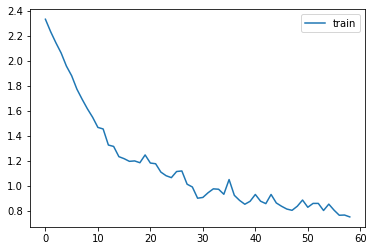

In [ ]:
cbs = [TrainCB(), CudaCB(), MetricsCB(Accuracy()), ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## Mixed Precision – Callback Exercise

We'll use mixed-precision training as a more complex example to exercise our callback mechanism.

If we take a look at the [previous implementation](https://github.com/fastai/fastai/blob/master/fastai/callback/fp16.py#L17) from `fastai 2`, we see that mixed precision requires injecting code at various stages during the training process. We'd like to do this as a callback, but training is a callback itself! We don't have enough places to hook on.

More concretely, we'd need callback events for `after_pred`, `after_loss` and others. This is a simplified version of the code, without grad scaling.

```Python
class MixedPrecision(Callback):
    order = 10
    def before_fit(self): 
        self.autocast = autocast()
    def before_batch(self): self.autocast.__enter__()
    def after_pred(self):
        if next(flatten(self.pred)).dtype==torch.float16: self.learn.pred = to_float(self.pred)
    def after_loss(self): self.autocast.__exit__(None, None, None)
```



We have `before_fit` and `before_batch` callbacks in our `Learner` class, but `predict` and `get_loss` are part of `TrainCB`, and we don't have `before_` or `after_` hooks for them.

What could we do?

- Incorporate those functions inside the `Learner` class and create callbacks for them. This is the obvious and possibly easiest solution, but it kind of forces us to use inheritance as our main abstraction.
- Subclass `TrainCB` creating a specialized version like `MixedPrecisionTrainCB`.

We'll explore something else here, which is a way to **compose callbacks** without tightly coupling them together.

Let's start by looking at the code we'd like to be able to see without worrying about how to do it:

```Python
cbs = [MixedPrecision(TrainCB()), MetricsCB(Accuracy()), ProgressCB()]
learn = Learner(model, dls, F.cross_entropy, lr=0.001, cbs=cbs)
learn.fit(1)
```

So `MixedPrecision` is a callback that wraps (or delegates to) `TrainCB`.

(Side thought: this could potentially be a way to sort out callback ordering for tasks that need to occur in specific order).

To achieve this, we create a `CallbackWrapper` (not a very good name) that automatically creates callbacks for the public methods of a `wrapped` Callback object. It leverages the `with_cbs` decorator to create the new callbacks. There are some Python gymnastics involved, but the basic idea is just to create those `before_` and `after_` hooks without having to modify anything in the target callback. Perhaps there's a better way to achieve the same, but this helped me better understand Python decorators.

In [ ]:
import inspect
import types

class CallbackWrapper(Callback):
    def __init__(self, wrapped):            
        self.wrapped = wrapped
        self.wrapped.callback = self.callback
        for name, fn in inspect.getmembers(wrapped.__class__, predicate=inspect.isfunction):
            if name.startswith("_"): continue
            # TODO: maybe ignore already wrapped?
            # TODO: provide name mapping so `after_get_loss` -> `after_loss` if we want
            setattr(wrapped, name, types.MethodType(with_cbs(name)(fn), wrapped))
            
    def __getattr__(self, name):
        if name[0]=='_': raise AttributeError(name)
        return getattr(self.wrapped, name)
    
    def __setattr__(self, name, value):
        # Magic name
        if name == "wrapped":
            super().__setattr__(name, value)
        else:
            setattr(self.wrapped, name, value)
            
    def callback(self, method_nm):
        getattr(self, method_nm, identity)()

With this in place we can now implement a simple tracing callback to see if it works.

In [ ]:
class Tracer(CallbackWrapper):
    def after_predict(self): print("after_predict")
    def after_get_loss(self): print("after_get_loss")

In [ ]:
cbs = [Tracer(TrainCB()), CudaCB(), MetricsCB(Accuracy()), ProgressCB()]
learn = Learner(model, dls, F.cross_entropy, lr=0.001, cbs=cbs)
learn.fit(1)

after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict
after_get_loss
after_predict


And then we can implement a very basic mixed precision callback.

In [ ]:
from itertools import chain
def flatten(lists): return chain.from_iterable(lists)

# TODO: copy from fastai implementation to deal with lists, dicts, etc.
def to_float(x):
    return x.float() if torch.is_floating_point(x) else x

In [ ]:
class MixedPrecision(CallbackWrapper):
    def before_fit(self):     self.autocast = torch.autocast("cuda")
    def before_batch(self):   self.autocast.__enter__()
    def after_predict(self):  self.learn.preds = to_float(self.learn.preds)
    def after_get_loss(self): self.autocast.__exit__(None, None, None)

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

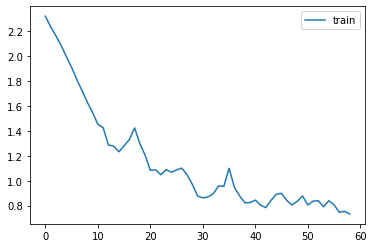

In [ ]:
cbs = [MixedPrecision(TrainCB()), CudaCB(), MetricsCB(Accuracy()), ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

The method feels fragile. Should we do something simpler?

## Accelerate

In [ ]:
from accelerate import Accelerator

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
class Distributed(CallbackWrapper):
    def __init__(self, wrapped):
        super().__init__(wrapped)
        self.accelerator = Accelerator()

    def before_fit(self):
        self.learn.model, self.learn.opt, self.learn.dls = self.accelerator.prepare(
            self.learn.model, self.learn.opt, self.learn.dls
        )

    # Replaces TrainCB.backward
    def backward(self): self.accelerator.backward(self.learn.loss)

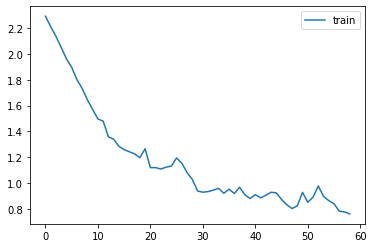

In [ ]:
cbs = [Distributed(TrainCB()), CudaCB(), MetricsCB(Accuracy()), ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

----

However, chaining multiple callbacks together doesn't work.

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

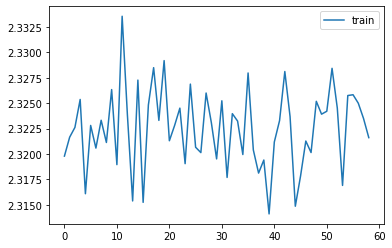

In [ ]:
cbs = [MixedPrecision(Distributed(TrainCB())), CudaCB(), MetricsCB(Accuracy()), ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

In [ ]:
cbs = [Distributed(MixedPrecision(TrainCB())), CudaCB(), MetricsCB(Accuracy()), ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_157780/2990819097.py:3 in <cell line: 3>                                   │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_157780/2990819097.py'                │
│ /home/pedro/code/hf/diffusers/fastai/course22p2/nbs/miniai/learner.py:145 in fit          │
│                                                                                           │
│   142 │   │   self.n_epochs = n_epochs                                                    │
│   143 │   │   self.epochs = range(n_epochs)                                               │
│   144 │   │   self.opt = self.opt_func(self.model.parameters(), self.lr)                  │
│ ❱ 145 │   │   self._fit()                                                                 │
│   146 │                                                                                   │
│   147 │   @with_cbs('fit')                                                                │
│   148 │   def _fit(self):                                                                 │
│                                                                                           │
│ /home/pedro/code/hf/diffusers/fastai/course22p2/nbs/miniai/learner.py:112 in _f           │
│                                                                                           │
│   109 │   │   def _f(o, *args, **kwargs):                                                 │
│   110 │   │   │   try:                                                                    │
│   111 │   │   │   │   o.callback(f'before_{self.nm}')                                     │
│ ❱ 112 │   │   │   │   f(o, *args, **kwargs)                                               │
│   113 │   │   │   │   o.callback(f'after_{self.nm}')                                      │
│   114 │   │   │   except globals()[f'Cancel{self.nm.title()}Exception']: pass             │
│   115 │   │   return _f                                                                   │
│                                                                                           │
│ /home/pedro/code/hf/diffusers/fastai/course22p2/nbs/miniai/learner.py:150 in _fit         │
│                                                                                           │
│   147 │   @with_cbs('fit')                                                                │
│   148 │   def _fit(self):                                                                 │
│   149 │   │   for self.epoch in self.epochs:                                              │
│ ❱ 150 │   │   │   self.one_epoch(True)                                                    │
│   151 │   │   │   self.one_epoch(False)                                                   │
│   152 │                                                                                   │
│   153 │   def __getattr__(self, name):                                                    │
│                                                                                           │
│ /home/pedro/code/hf/diffusers/fastai/course22p2/nbs/miniai/learner.py:135 in one_epoch    │
│                                                                                           │
│   132 │   def one_epoch(self, train):                                                     │
│   133 │   │   self.model.train(train)                                                     │
│   134 │   │   self.dl = self.dls.train if train else self.dls.valid                       │
│ ❱ 135 │   │   self._one_epoch()                                                           │
│   136 │                                                                                   │
│   137 │   @with_cbs('epoch')                      